In [27]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
from scipy.stats import pearsonr

In [28]:
runs_all = []

# Loop through the file names and read each file
for i in range(1, 5):
    file_name = f"data/runs_{i}.json"
    with open(file_name, "r") as f:
        data = json.load(f)
        runs_all.extend(data)  # Combine the data from the current file with the previous ones

# Save the combined data to a new JSON file
with open("data/runs_combined.json", "w") as f:
    json.dump(runs_all, f)

# Load baseline (w/o any data augmentation)
with open("data/baseline.json", "r") as f:
    baseline = json.load(f)

In [30]:
runs_demonstrations = [run for run in runs_all if run['prompt_augmentation'] == 'demonstrations']
runs_both = [run for run in runs_all if run['prompt_augmentation'] == 'both']
runs_query = [run for run in runs_all if run['prompt_augmentation'] == 'query']

In [32]:
selected_tasks = [1, 12, 14, 16]
metrics = {
    'accuracy': 'acc',
    'prediction_perplexity': 'ppl_pr',
    'target_perplexity': 'ppl_ta'
}

# Initialize data dictionaries for both, query, and demonstrations
data_both = {task: {} for task in selected_tasks}
data_query = {task: {} for task in selected_tasks}
data_demons = {task: {} for task in selected_tasks}

# Fill data dictionaries with metric values for each task
for task in selected_tasks:
    for metric, short_name in metrics.items():
        data_both[task][short_name] = pd.Series(run[f"task{task}"][metric] for run in runs_both)
        data_query[task][short_name] = pd.Series(run[f"task{task}"][metric] for run in runs_query)
        data_demons[task][short_name] = pd.Series(run[f"task{task}"][metric] for run in runs_demonstrations)


In [33]:
df = pd.read_csv("data/entities_metadata.csv")

# Extract entities for both, query, and demonstrations
entities_both = [run["entity_augmentation"].split("_")[-1] for run in runs_both]
entities_query = [run["entity_augmentation"].split("_")[-1] for run in runs_query]
entities_demonstrations = [run["entity_augmentation"].split("_")[-1] for run in runs_demonstrations]

# Create a dictionary with text as key and occurrences as value
occurrences_dict = df.set_index('text')['occurrences'].to_dict()

# Get occurrences for both, query, and demonstrations using the occurrences_dict
occurrences_both = pd.Series(occurrences_dict[entity] for entity in entities_both)
occurrences_query = pd.Series(occurrences_dict[entity] for entity in entities_query)
occurrences_demonstrations = pd.Series(occurrences_dict[entity] for entity in entities_demonstrations)

In [34]:
# Dictionary for metric labels of y axis
metric_labels = {
    'acc': 'Accuracy',
    'ppl_pr': 'Perplexity of prompt',
    'ppl_ta': 'Perplexity of correct answer',
}

# Dictionary for reading baseline
baseline_labels = {
    'acc': 'accuracy',
    'ppl_pr': 'prediction_perplexity',
    'ppl_ta': 'target_perplexity',
}

def plot_task_metrics(task):
    # Fig1, Fig2, and Fig3
    for metric in ['acc', 'ppl_pr', 'ppl_ta']:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

        # Plot data augmentation only in Demonstrations
        axs[0].plot(list(occurrences_demonstrations), list(data_demons[task][metric]), 'go', alpha=0.5)
        axs[0].set_title(f"Demonstrations (Task{task})")
        axs[0].set_xlabel("Entity occurrence")
        axs[0].set_ylabel(metric_labels[metric])
        # Plot baseline
        axs[0].axhline(y=baseline[f"task{task}"][baseline_labels[metric]], color = 'r')

        # Plot data augmentation both in Query and demonstrations
        axs[1].plot(list(occurrences_both), list(data_both[task][metric]), 'o', alpha=0.5)
        axs[1].set_title(f"Query and demonstrations (Task{task})")
        axs[1].set_xlabel("Entity occurrence")
        # Plot baseline
        axs[1].axhline(y=baseline[f"task{task}"][baseline_labels[metric]], color = 'r')

        # Plot data augmentation only in Query
        axs[2].plot(list(occurrences_query), list(data_query[task][metric]), 'yo', alpha=0.5)
        axs[2].set_title(f"Query (Task{task})")
        axs[2].set_xlabel("Entity occurrence")
        # Plot baseline
        axs[2].axhline(y=baseline[f"task{task}"][baseline_labels[metric]], color = 'r')

        plt.tight_layout()
        plt.show()
        print('\n')

    # Fig4
    metric_y = 'acc'
    metric_x = 'ppl_pr'
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    demonstrations_corr, _ = pearsonr(list(data_demons[task][metric_x]), list(data_demons[task][metric_y]))
    axs[0].plot(list(data_demons[task][metric_x]), list(data_demons[task][metric_y]), 'go', alpha=0.5, label=f'Pearson r: {demonstrations_corr:.2f}')
    axs[0].set_title(f"Demonstrations (Task{task})")
    axs[0].set_xlabel(metric_labels[metric_x])
    axs[0].set_ylabel(metric_labels[metric_y])
    # Plot baseline
    axs[0].axhline(y=baseline[f"task{task}"][baseline_labels[metric_y]], color = 'r')
    axs[0].axvline(x=baseline[f"task{task}"][baseline_labels[metric_x]], color = 'r')
    axs[0].legend()

    # Plot data augmentation both in Query and demonstrations
    query_demonstrations_corr, _ = pearsonr(list(data_both[task][metric_x]), list(data_both[task][metric]))
    axs[1].plot(list(data_both[task][metric_x]), list(data_both[task][metric_y]), 'o', alpha=0.5, label=f'Pearson r: {query_demonstrations_corr:.2f}')
    axs[1].set_title(f"Query and demonstrations (Task{task})")
    axs[1].set_xlabel(metric_labels[metric_x])
    # Plot baseline
    axs[1].axhline(y=baseline[f"task{task}"][baseline_labels[metric_y]], color = 'r')
    axs[1].axvline(x=baseline[f"task{task}"][baseline_labels[metric_x]], color = 'r')
    axs[1].legend()

    # Plot data augmentation only in Query
    query_corr, _ = pearsonr(list(data_query[task][metric_x]), list(data_query[task][metric_y]))
    axs[2].plot(list(data_query[task][metric_x]), list(data_query[task][metric_y]), 'yo', alpha=0.5, label=f'Pearson r: {query_corr:.2f}')
    axs[2].set_title(f"Query (Task{task})")
    axs[2].set_xlabel(metric_labels[metric_x])
    # Plot baseline
    axs[2].axhline(y=baseline[f"task{task}"][baseline_labels[metric_y]], color = 'r')
    axs[2].axvline(x=baseline[f"task{task}"][baseline_labels[metric_x]], color = 'r')
    axs[2].legend()

    plt.tight_layout()
    plt.show()


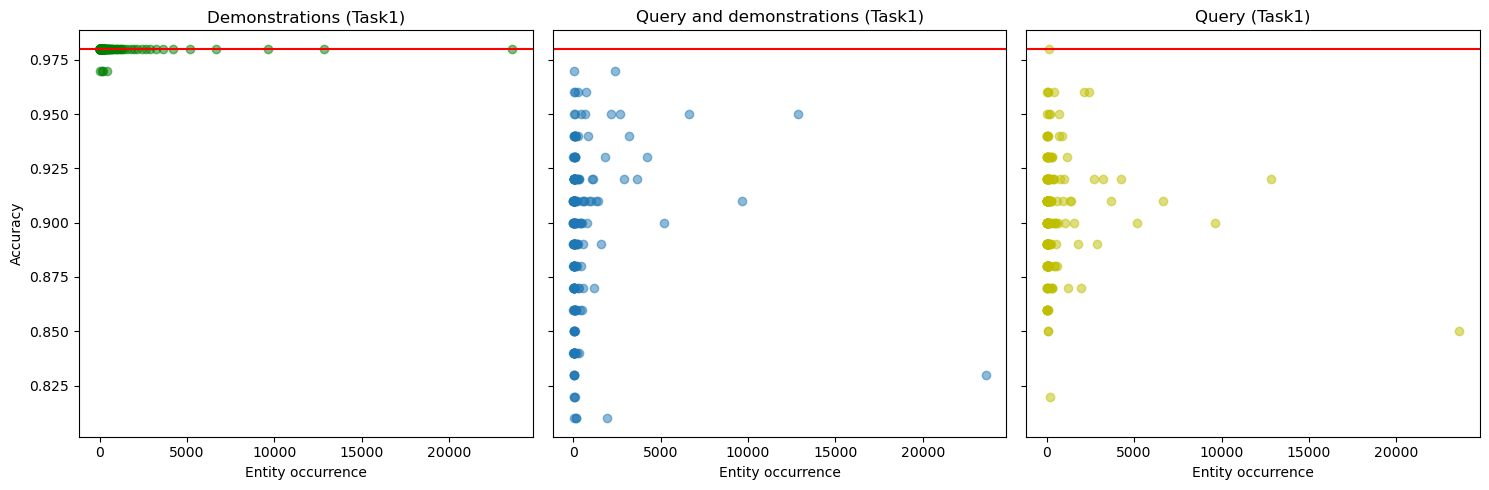

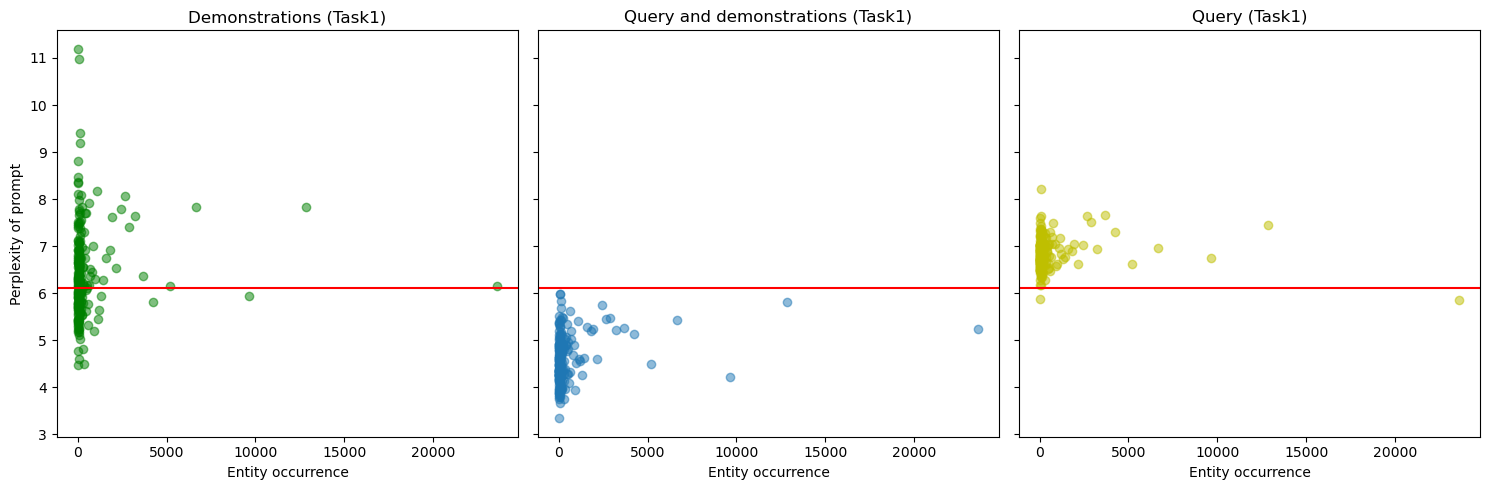

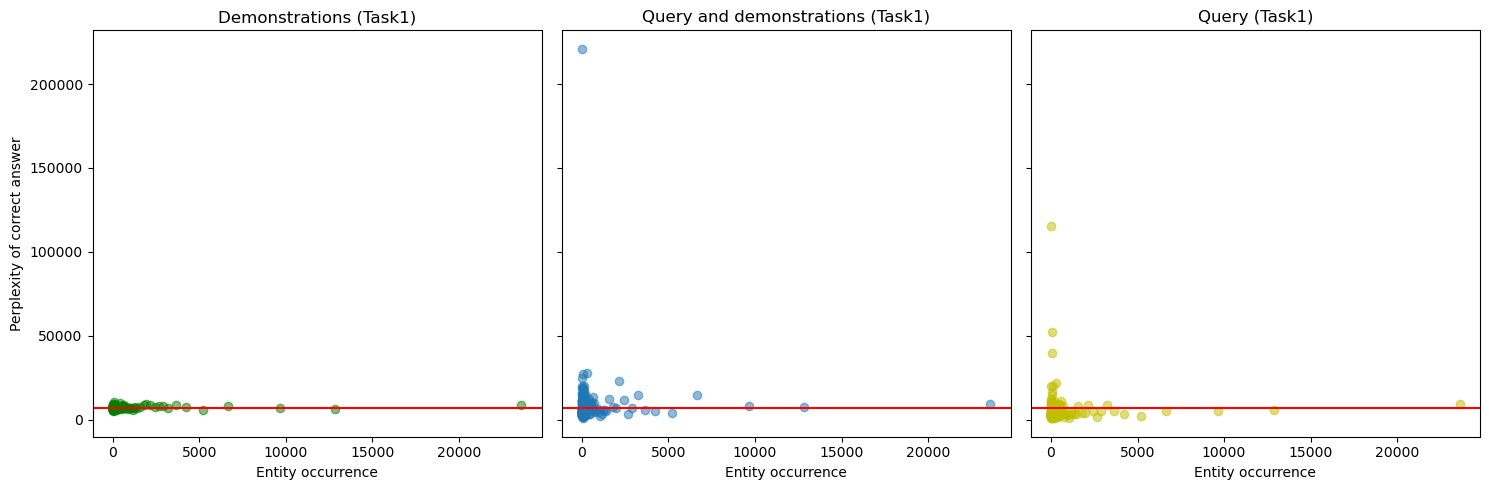

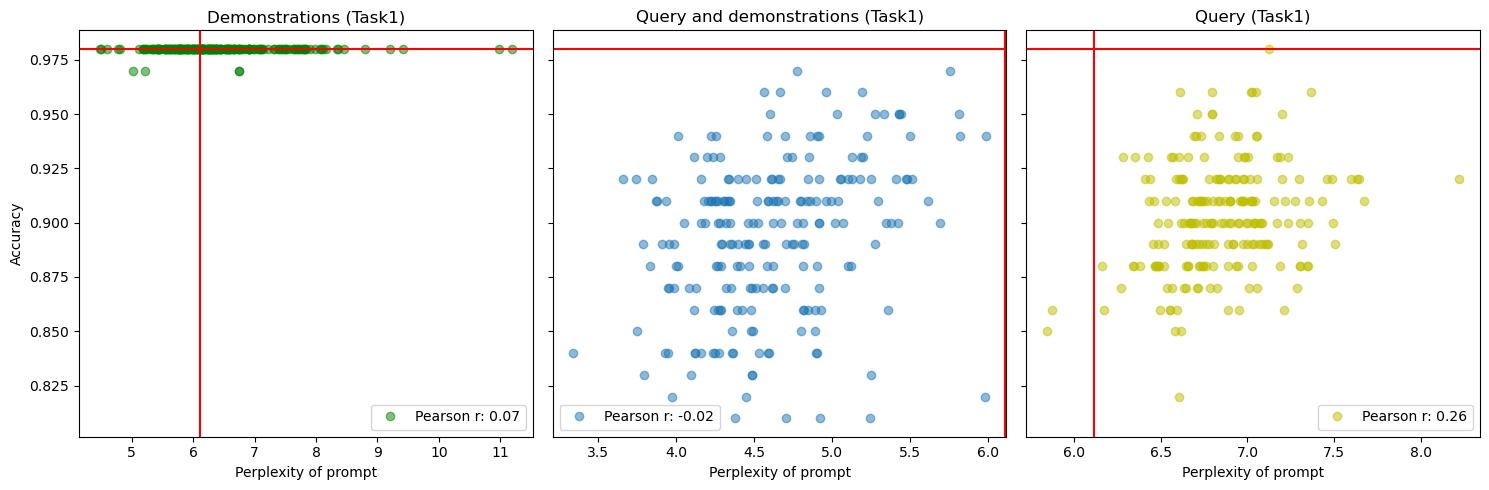

In [35]:
# Task1
plot_task_metrics(task=1)

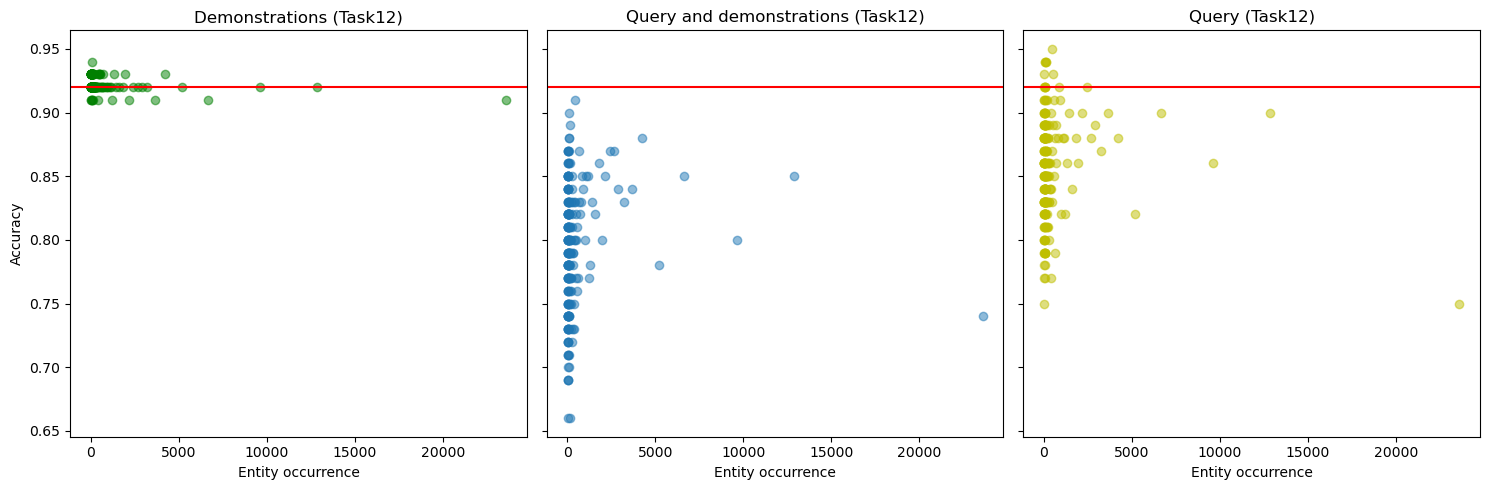

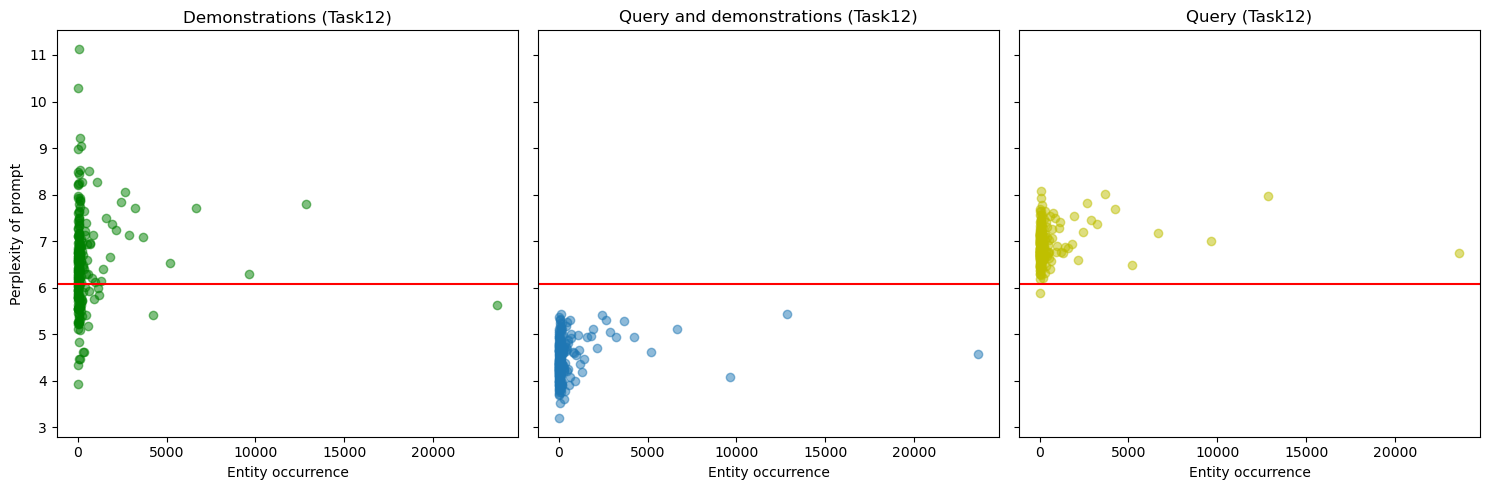

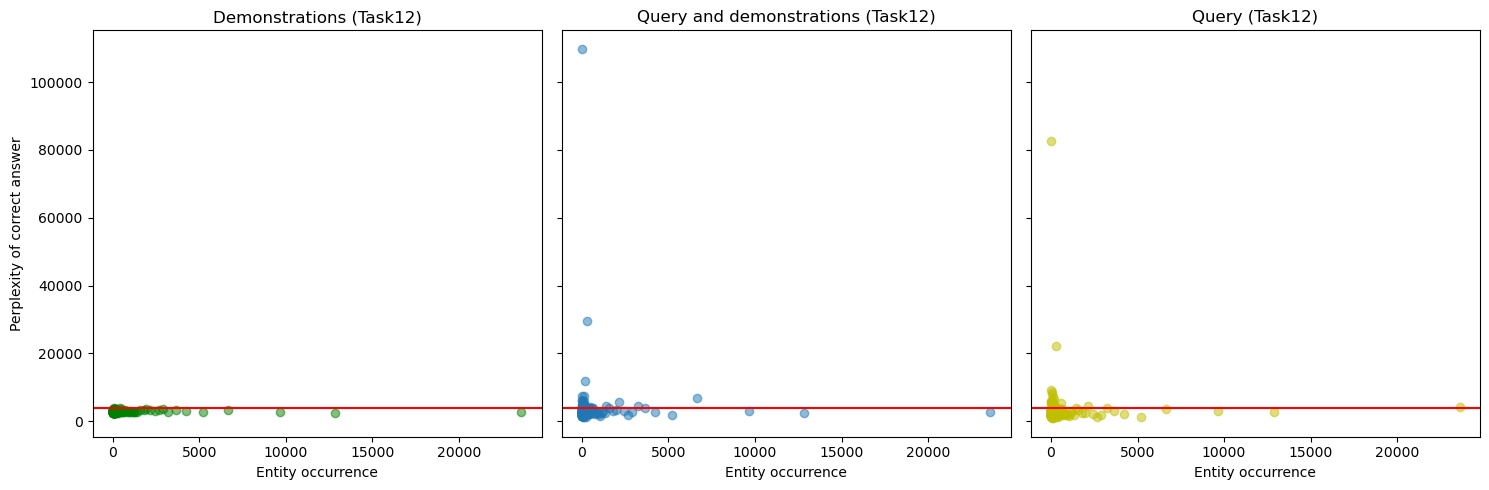

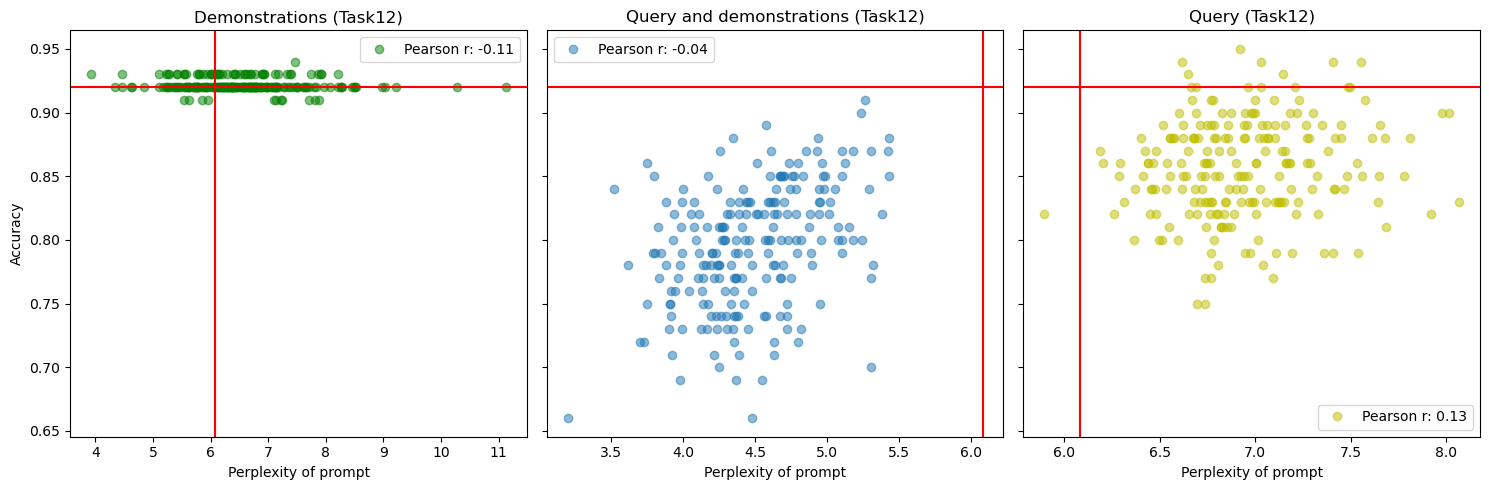

In [36]:
# Task12
plot_task_metrics(task=12)

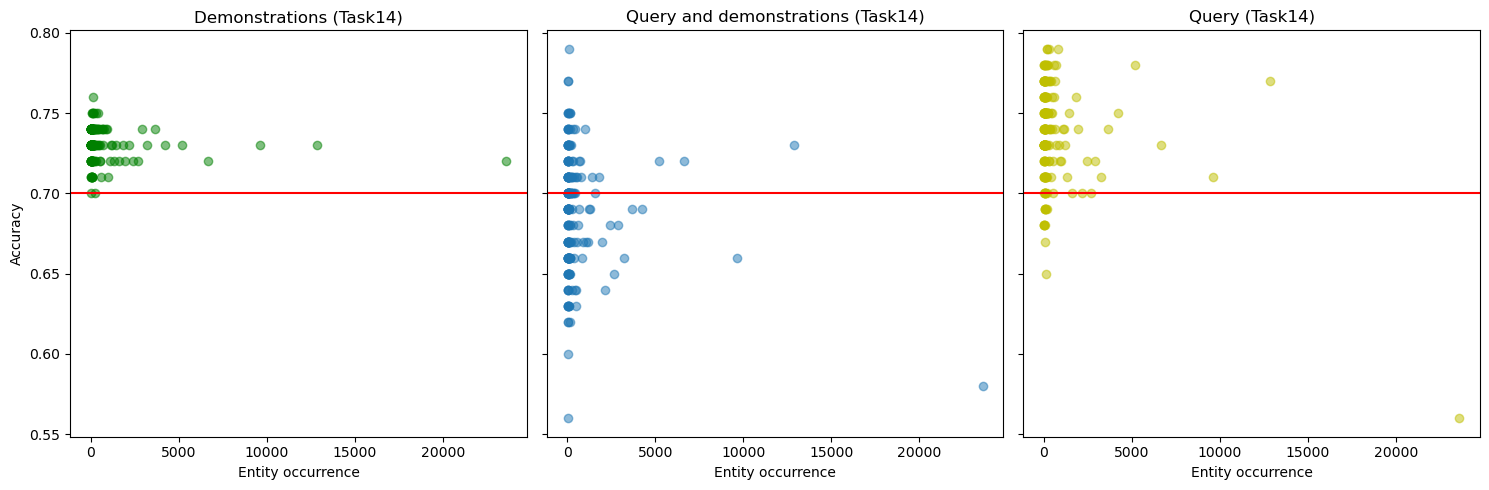

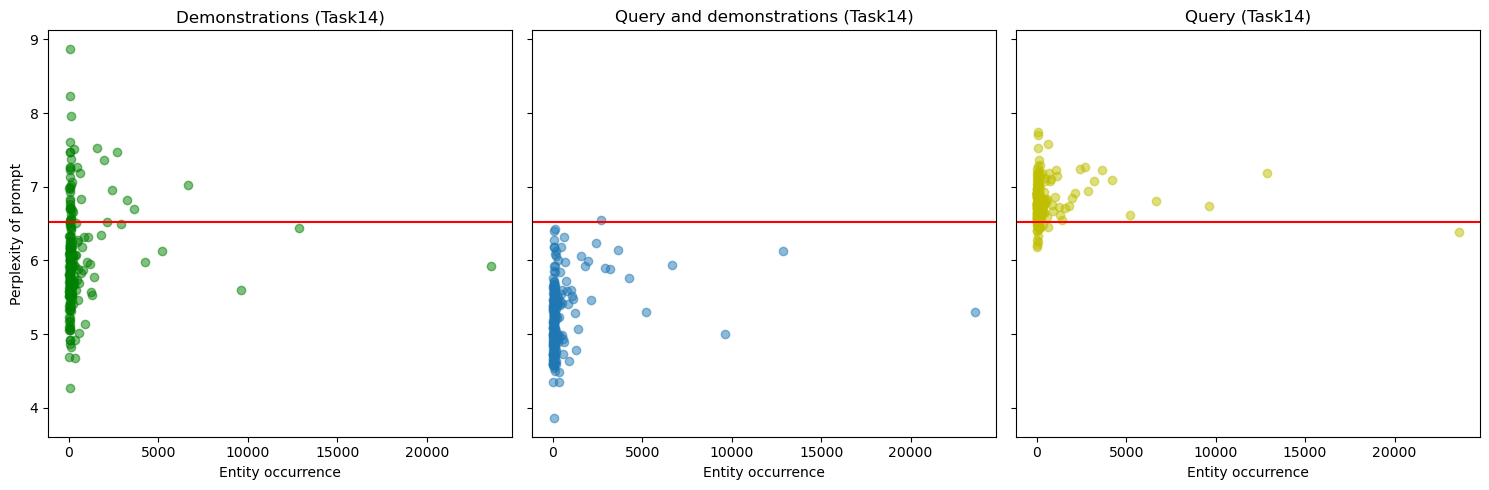

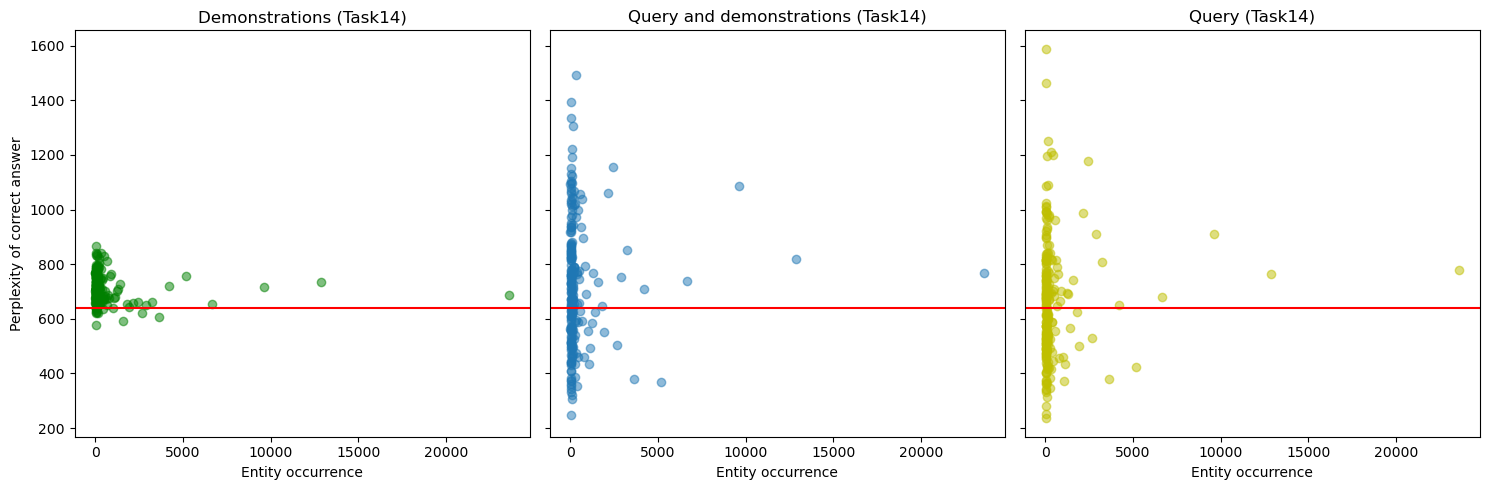

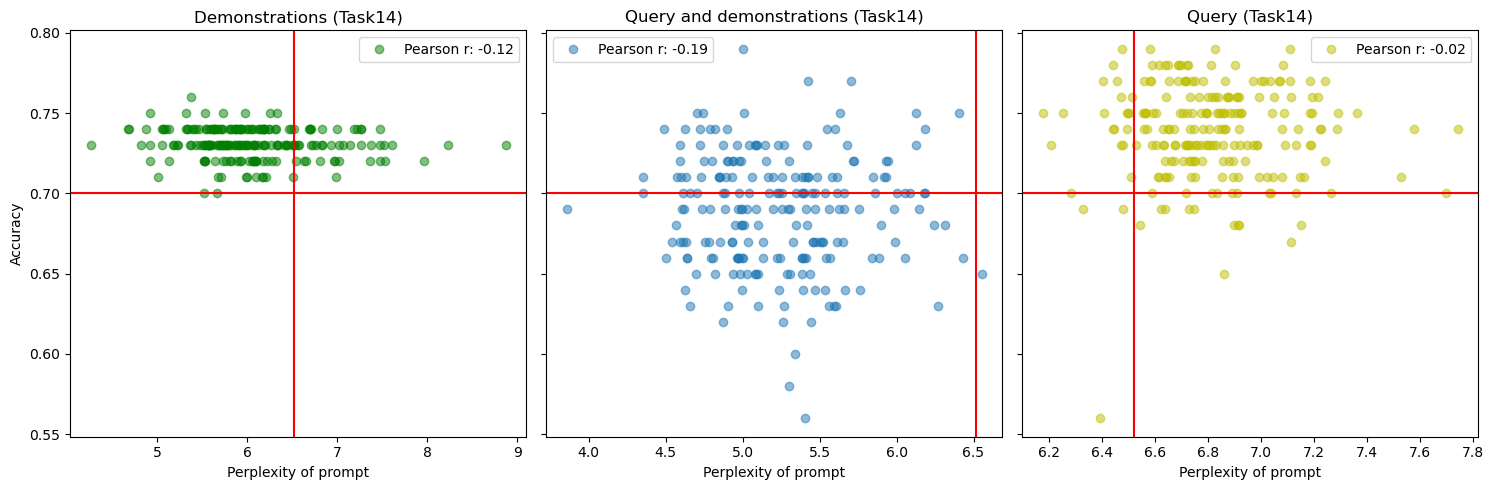

In [37]:
# Task14
plot_task_metrics(task=14)

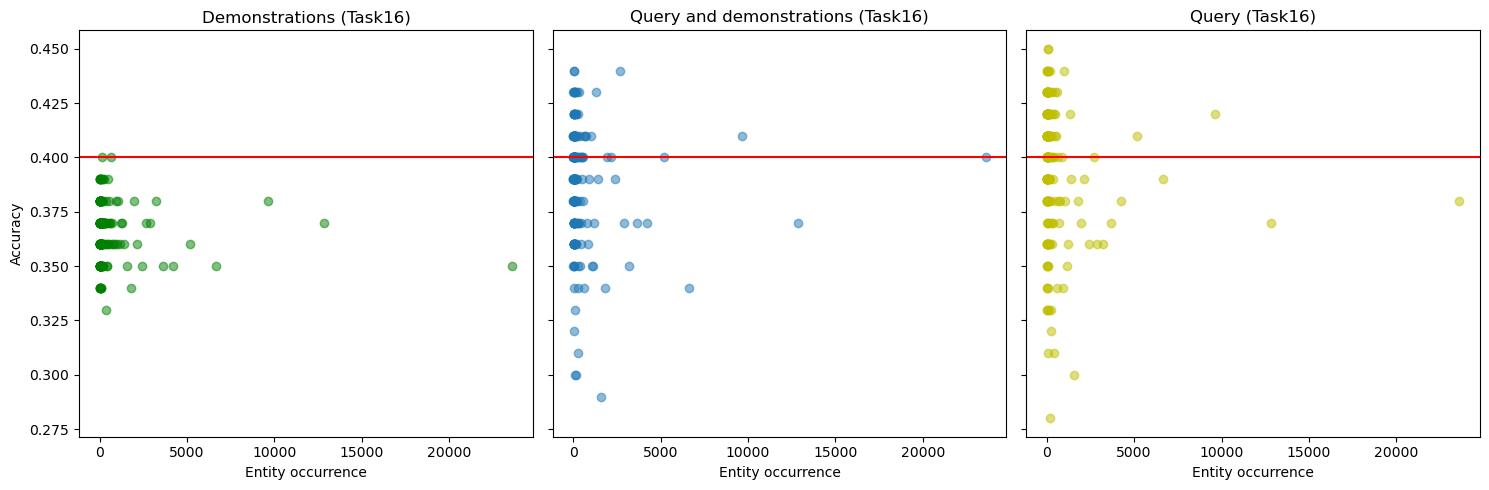

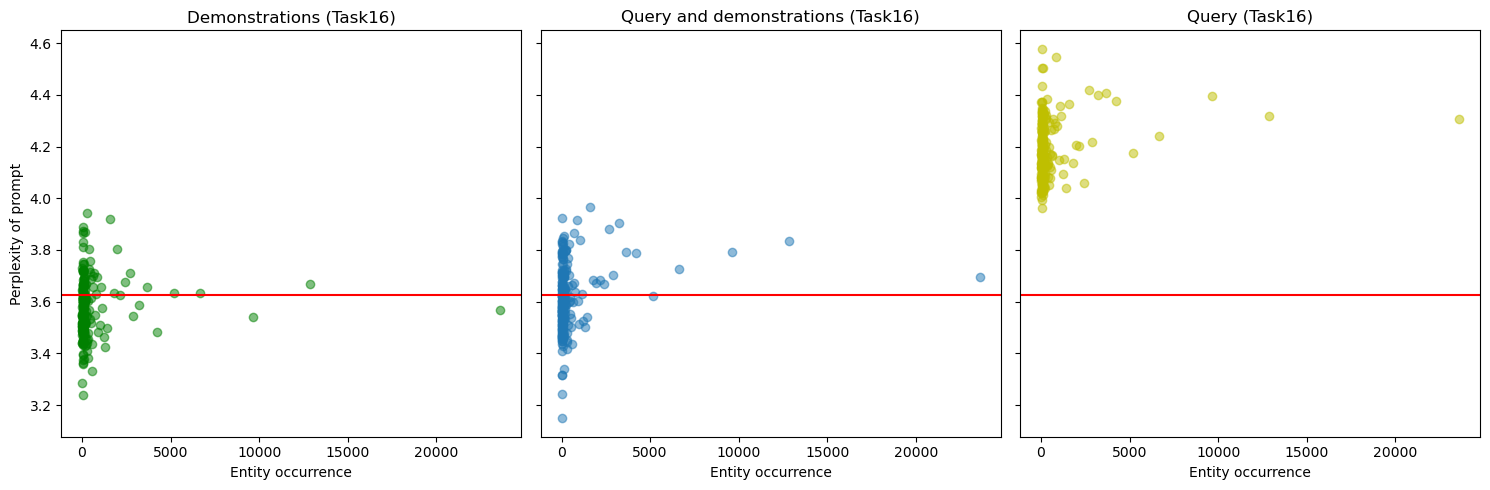

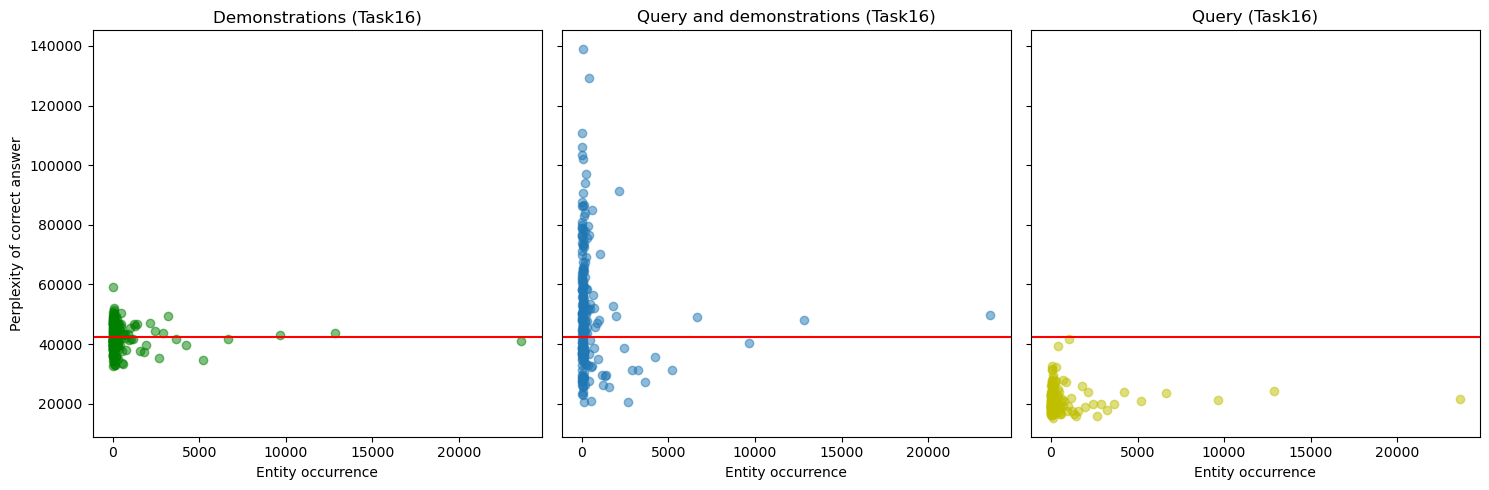

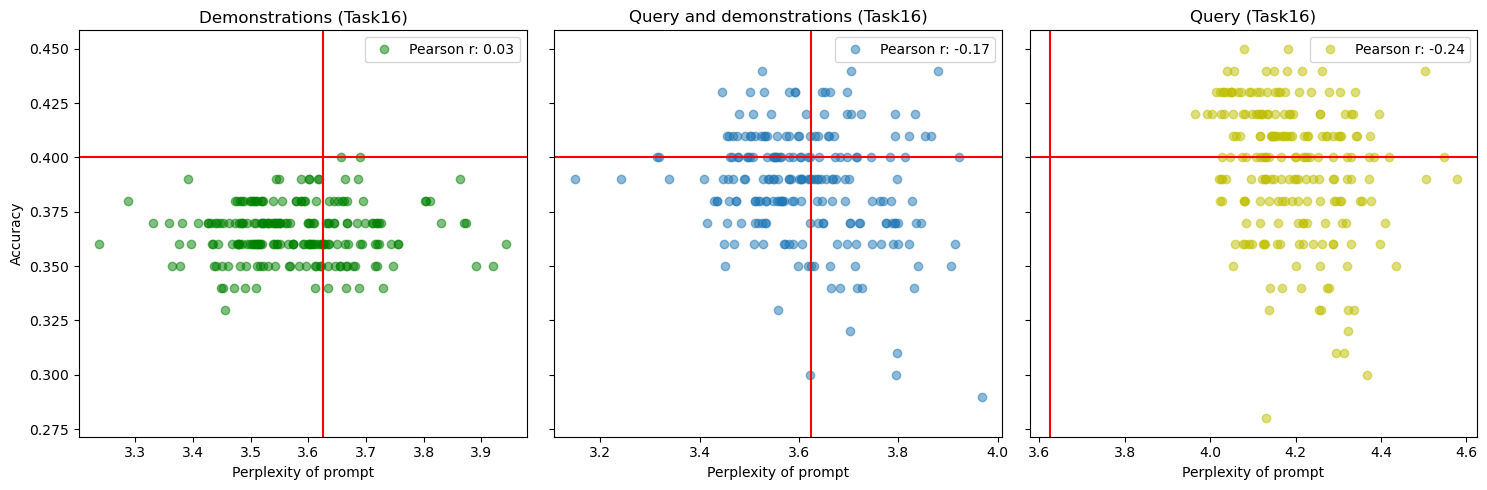

In [38]:
# Task16
plot_task_metrics(task=16)

# Ploting Deviation from baseline

In [39]:
def plot_deviation_task_metrics(task):
    # Fig1, Fig2, and Fig3
    for metric in ['acc', 'ppl_pr', 'ppl_ta']:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
        baseline_value = baseline[f"task{task}"][baseline_labels[metric]]

        # Plot data augmentation only in Demonstrations
        deviation_demonstrations = data_demons[task][metric] - baseline_value
        axs[0].plot(list(occurrences_demonstrations), deviation_demonstrations, 'go', alpha=0.5)
        axs[0].set_title(f"Demonstrations (Task{task})")
        axs[0].set_xlabel("Entity occurrence")
        axs[0].set_ylabel(f"Deviation from baseline ({metric_labels[metric]})")

        # Plot data augmentation both in Query and demonstrations
        deviation_both = data_both[task][metric] - baseline_value
        axs[1].plot(list(occurrences_both), deviation_both, 'o', alpha=0.5)
        axs[1].set_title(f"Query and demonstrations (Task{task})")
        axs[1].set_xlabel("Entity occurrence")

        # Plot data augmentation only in Query
        deviation_query = data_query[task][metric] - baseline_value
        axs[2].plot(list(occurrences_query), deviation_query, 'yo', alpha=0.5)
        axs[2].set_title(f"Query (Task{task})")
        axs[2].set_xlabel("Entity occurrence")

        plt.tight_layout()
        plt.show()
        print('\n')

    # Fig4
    metric = 'acc'
    metric_x = 'ppl_pr'
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    baseline_value_x = baseline[f"task{task}"][baseline_labels[metric_x]]
    baseline_value_y = baseline[f"task{task}"][baseline_labels[metric]]

    demonstrations_corr, _ = pearsonr(list(data_demons[task][metric_x]), list(data_demons[task][metric]))
    axs[0].plot(data_demons[task][metric_x] - baseline_value_x, data_demons[task][metric] - baseline_value_y, 'go', alpha=0.5, label=f'Pearson r: {demonstrations_corr:.2f}')
    axs[0].set_title(f"Demonstrations (Task{task})")
    axs[0].set_xlabel(f"Deviation from baseline ({metric_labels[metric_x]})")
    axs[0].set_ylabel(f"Deviation from baseline ({metric_labels[metric]})")
    axs[0].legend()

    # Plot data augmentation both in Query and demonstrations
    query_demonstrations_corr, _ = pearsonr(list(data_both[task][metric_x]), list(data_both[task][metric]))
    axs[1].plot(data_both[task][metric_x] - baseline_value_x, data_both[task][metric] - baseline_value_y, 'o', alpha=0.5, label=f'Pearson r: {query_demonstrations_corr:.2f}')
    axs[1].set_title(f"Query and demonstrations (Task{task})")
    axs[1].set_xlabel(f"Deviation from baseline ({metric_labels[metric_x]})")
    axs[1].legend()

    # Plot data augmentation only in Query
    query_corr, _ = pearsonr(list(data_query[task][metric_x]), list(data_query[task][metric]))
    axs[2].plot(data_query[task][metric_x] - baseline_value_x, data_query[task][metric] - baseline_value_y, 'yo', alpha=0.5, label=f'Pearson r: {query_corr:.2f}')
    axs[2].set_title(f"Query (Task{task})")
    axs[2].set_xlabel(f"Deviation from baseline ({metric_labels[metric_x]})")
    axs[2].legend()

    plt.tight_layout()
    plt.show()


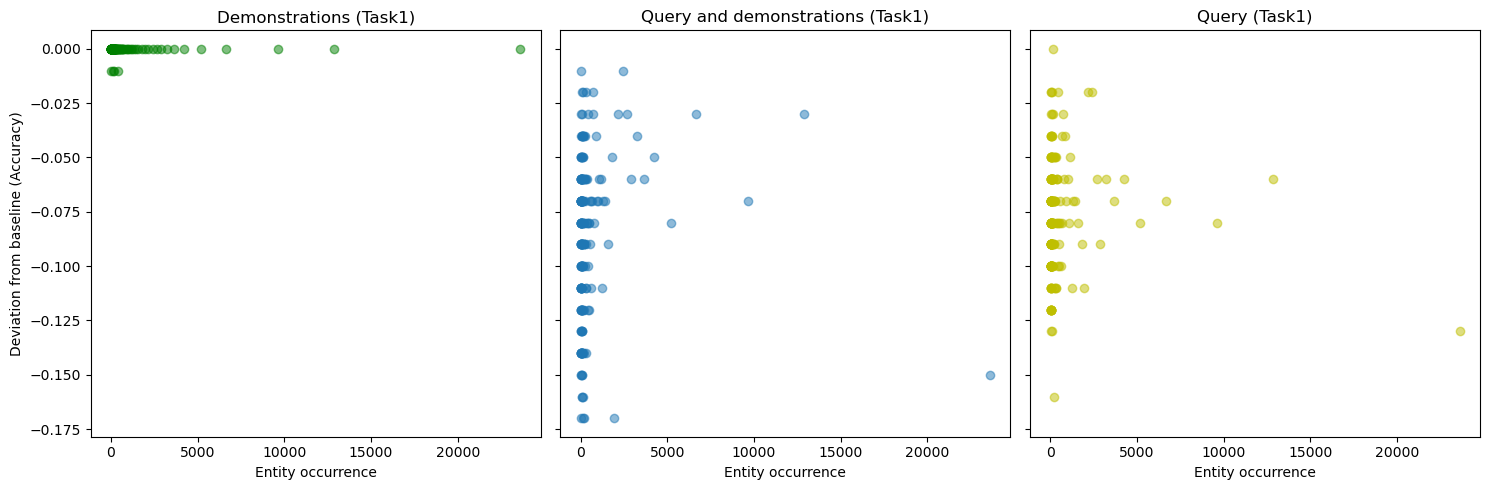

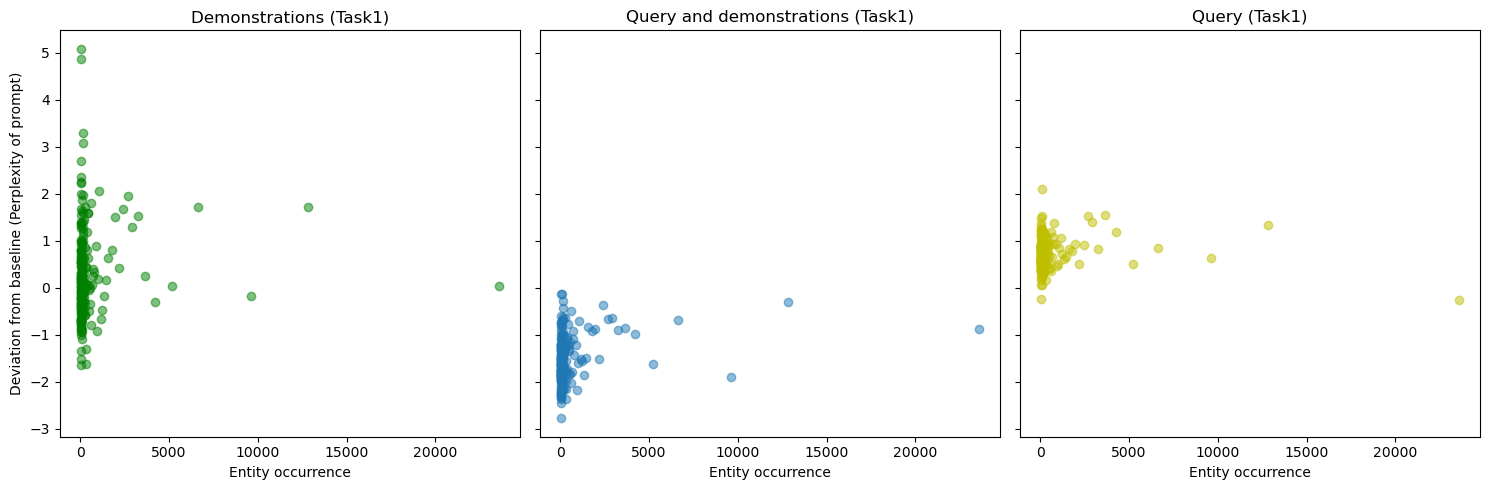

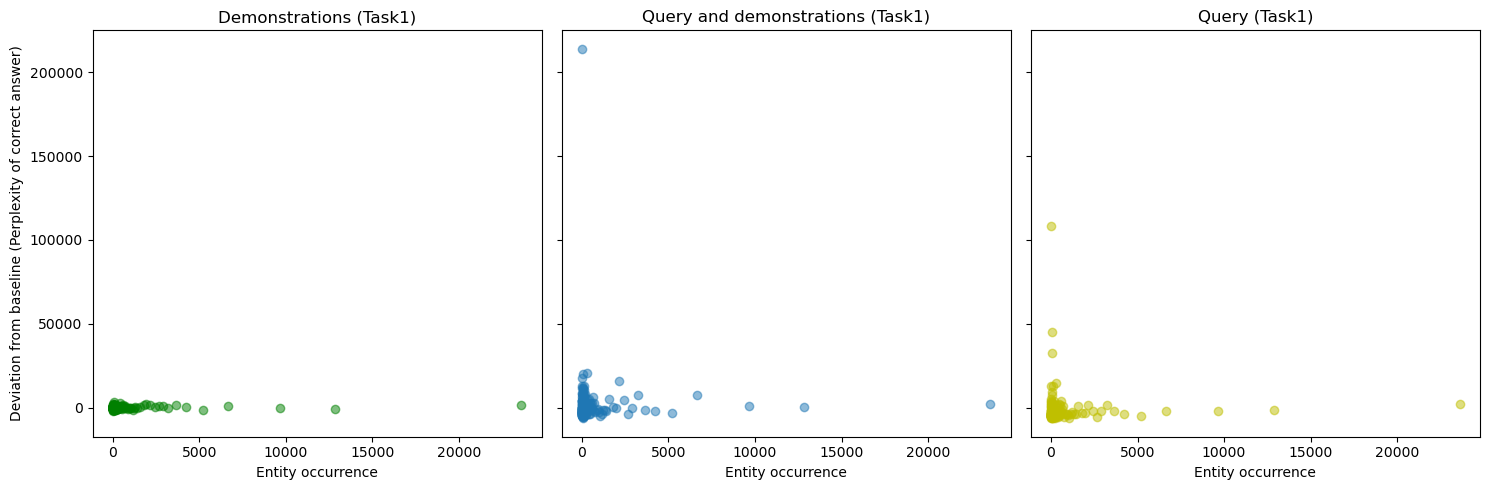

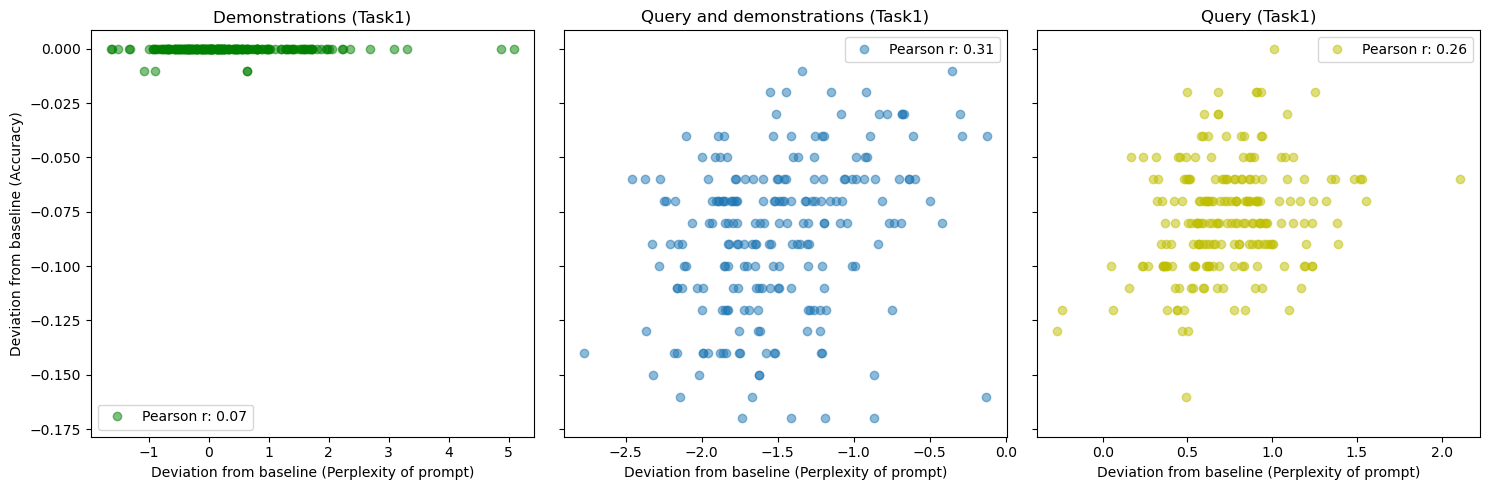

In [40]:
# Task1
plot_deviation_task_metrics(task=1)

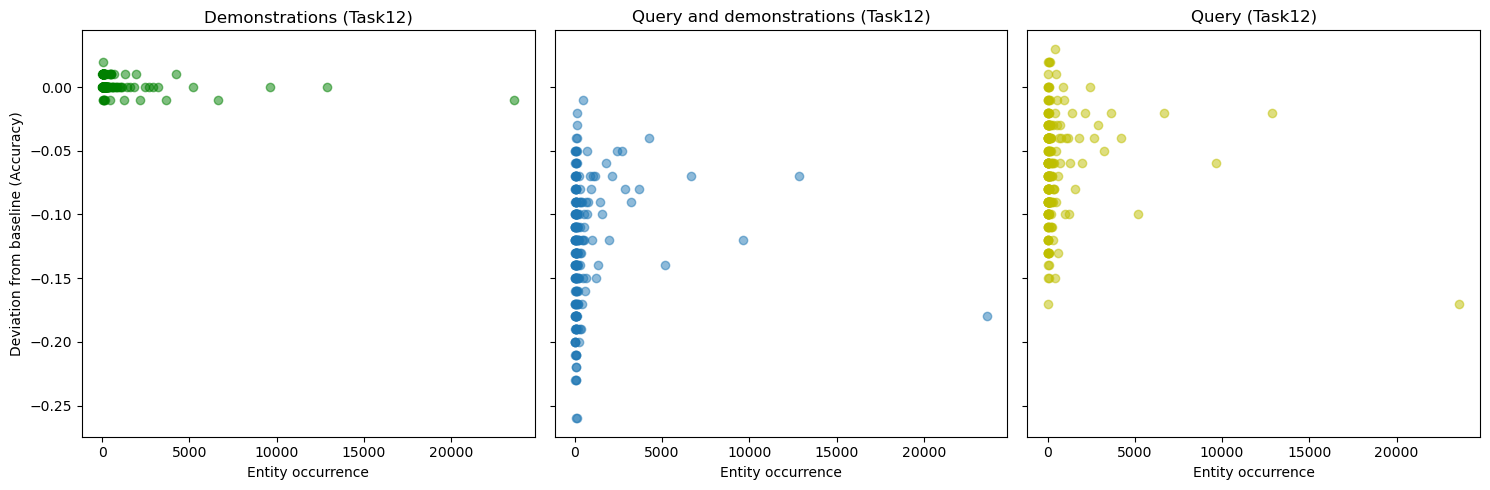

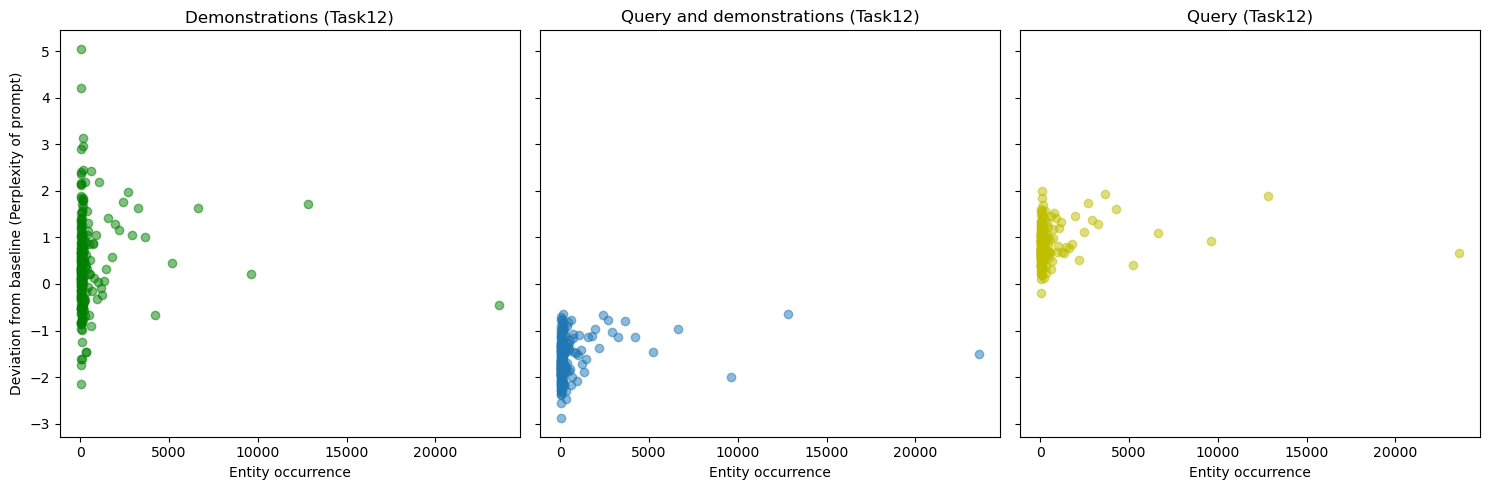

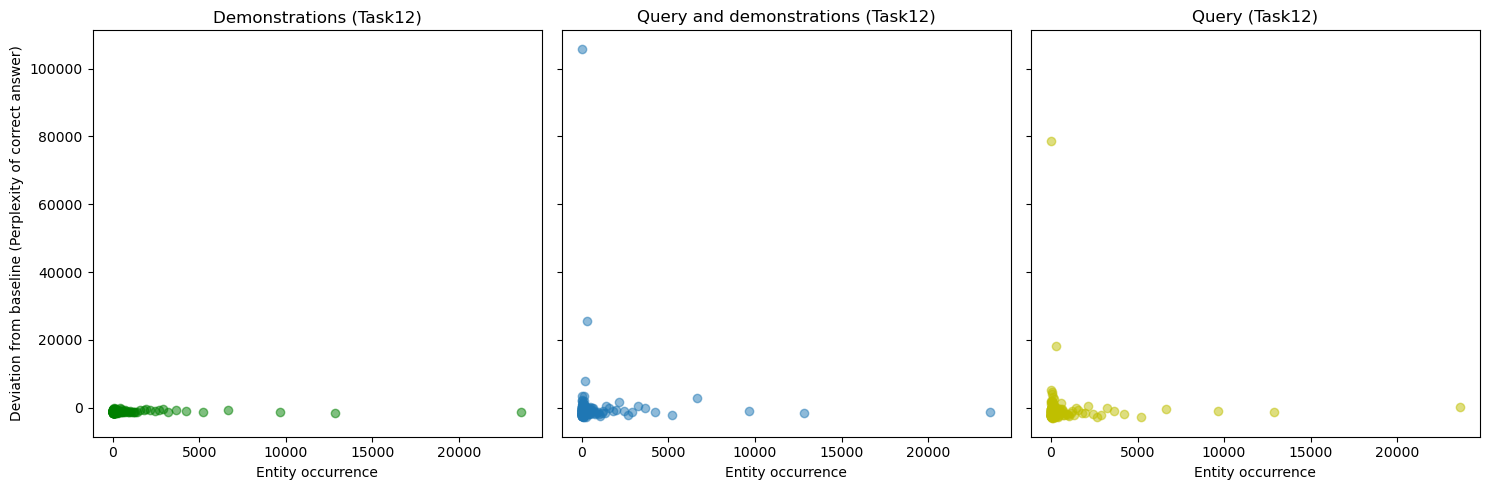

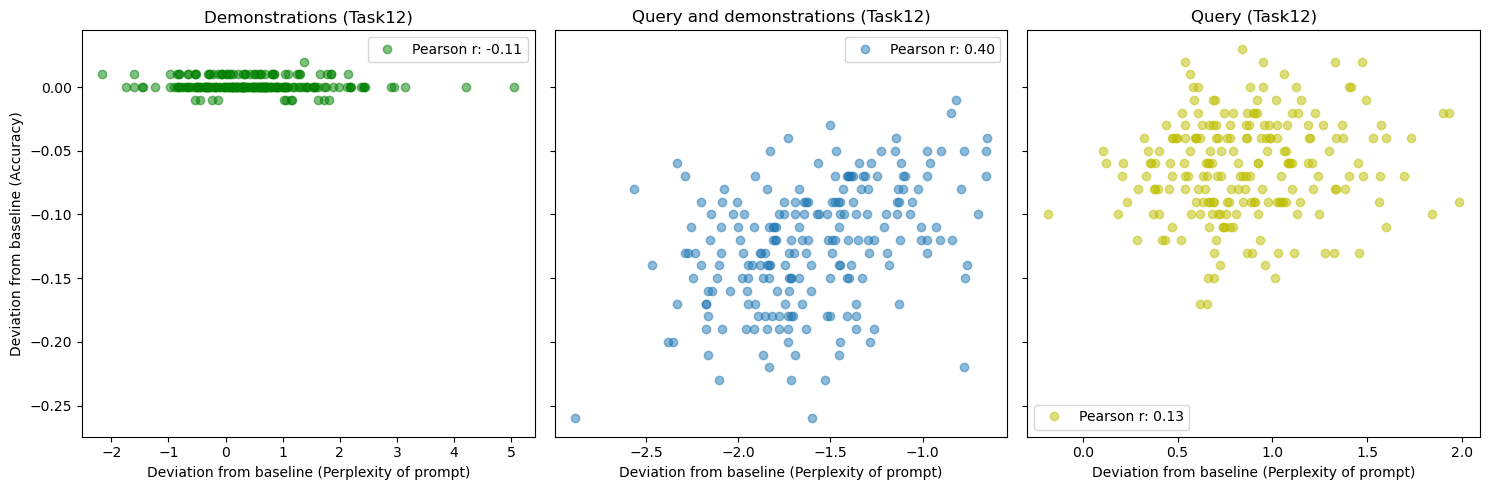

In [41]:
# Task12
plot_deviation_task_metrics(task=12)

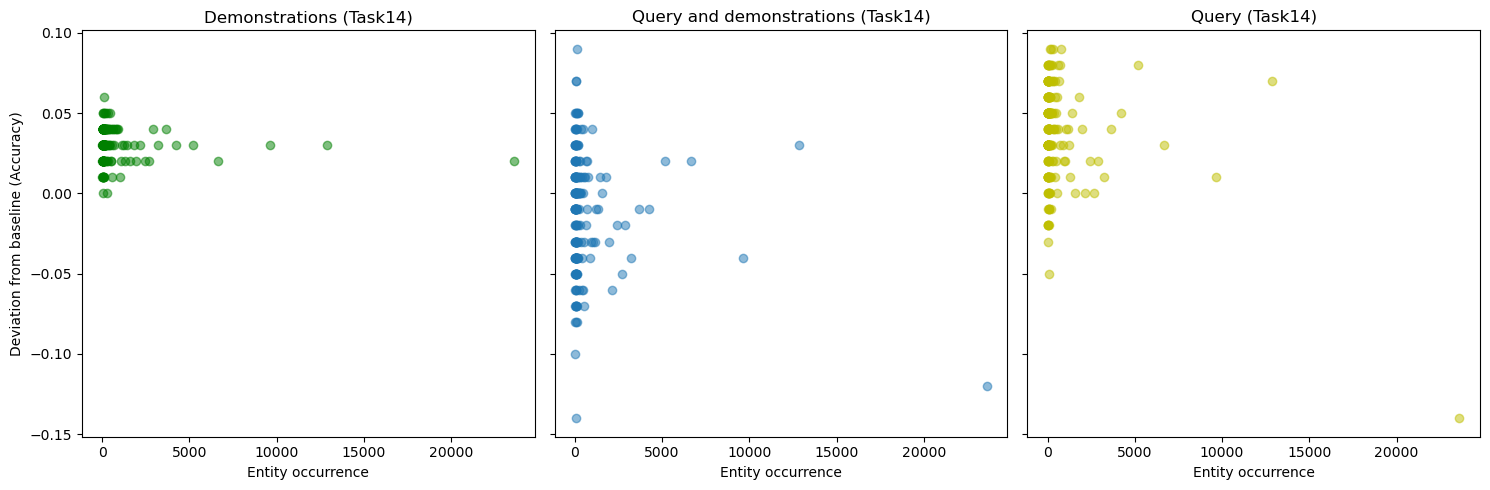

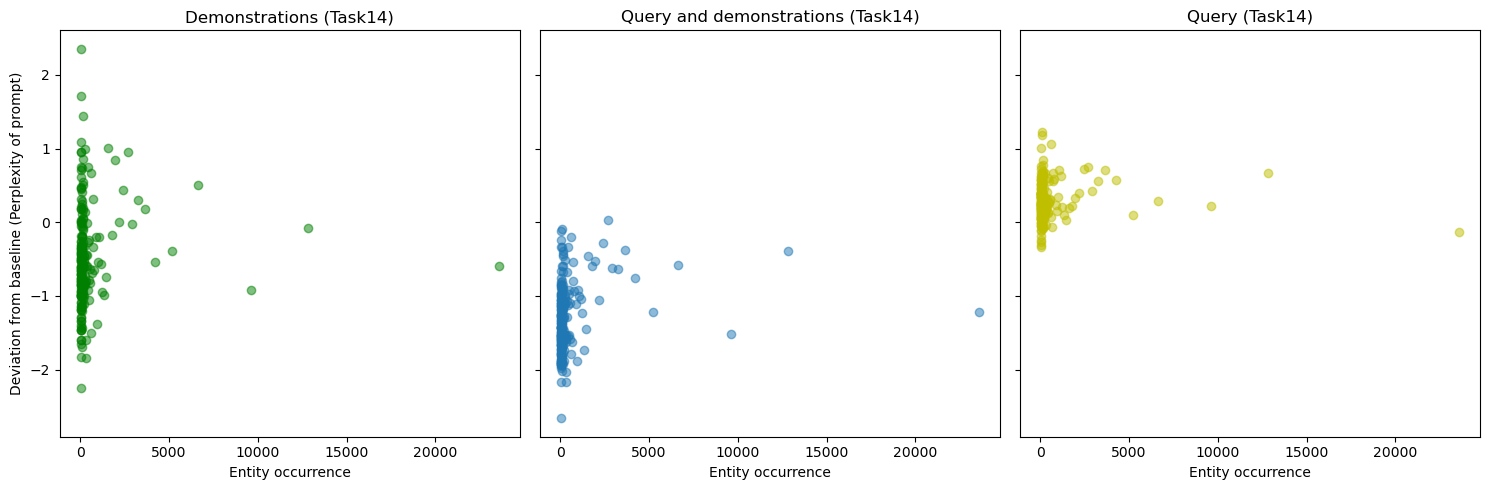

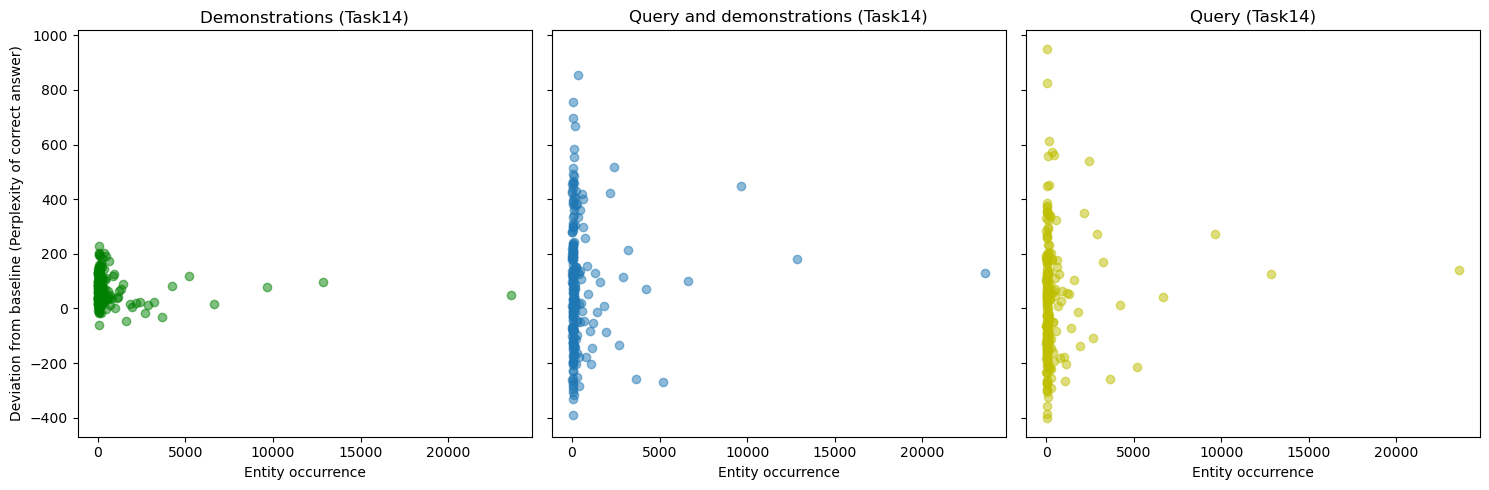

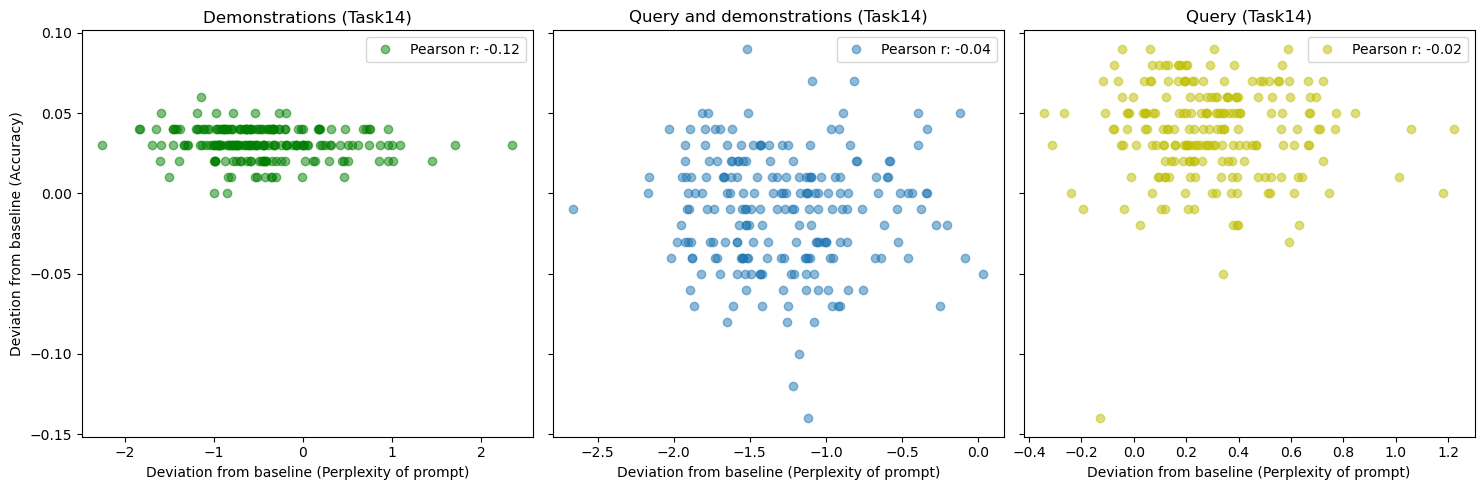

In [42]:
# Task14
plot_deviation_task_metrics(task=14)

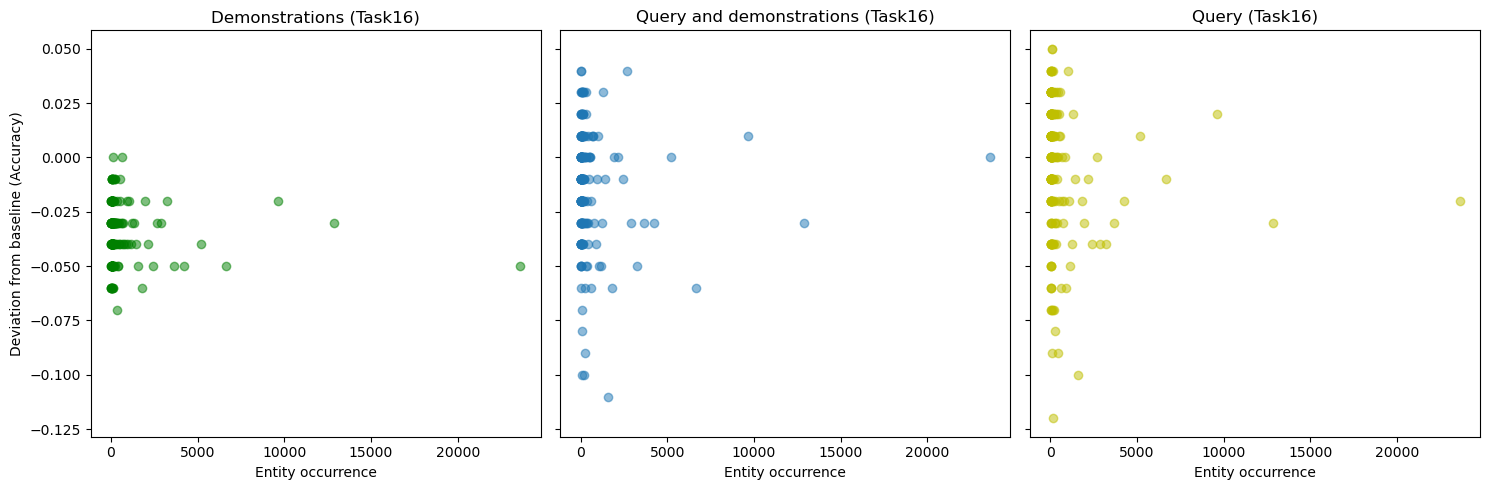

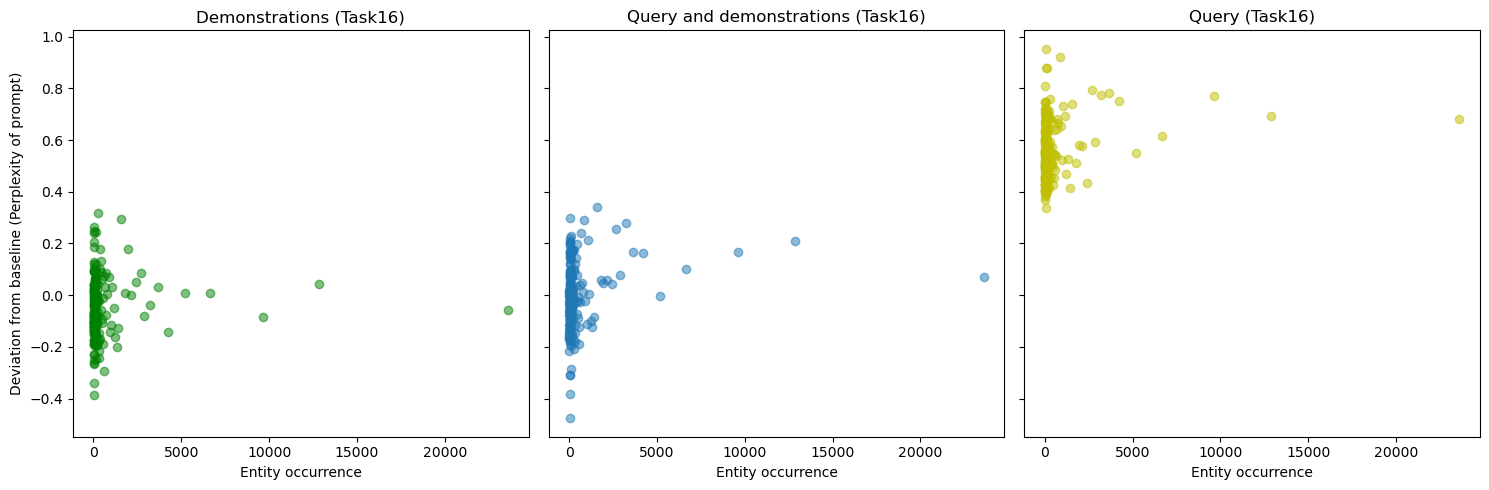

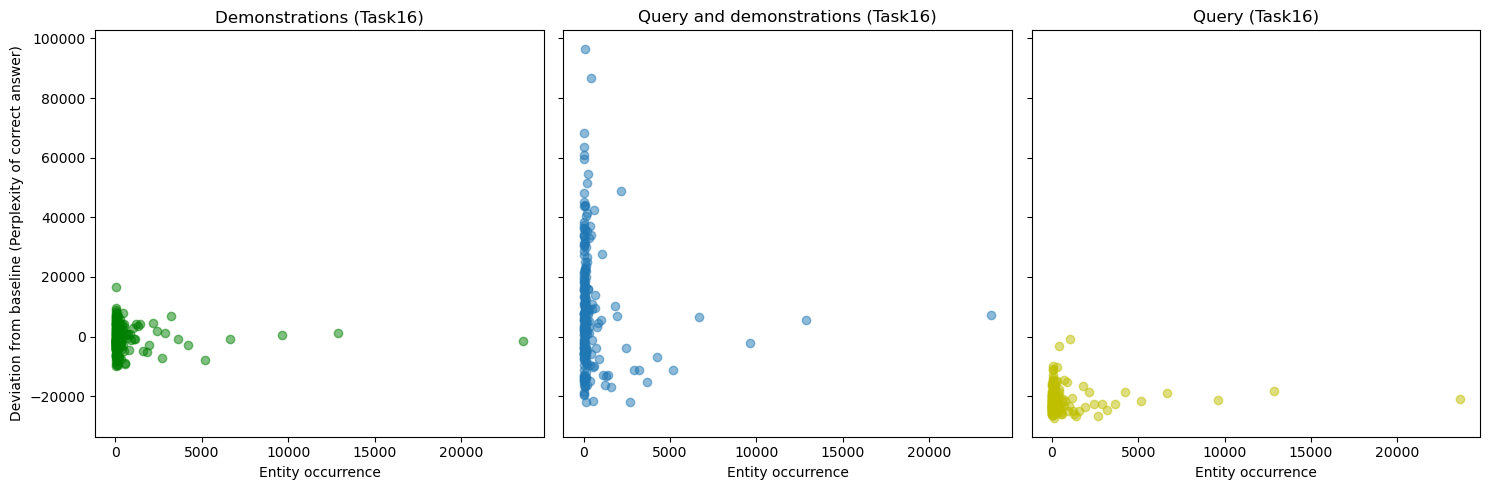

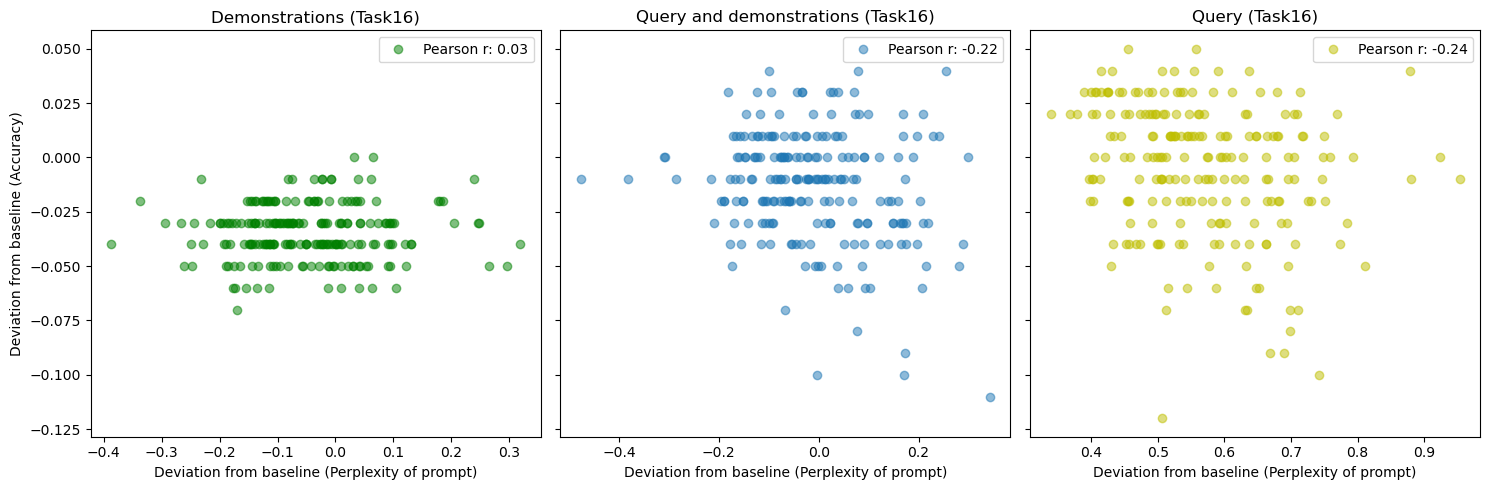

In [43]:
# Task16
plot_deviation_task_metrics(task=16)